Аксененко Вероника 

# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [33]:
%pip install -q moviepy --upgrade
%pip install -q ffmpeg --upgrade

In [34]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("/content/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
video.fps

23.976023976023978

In [38]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


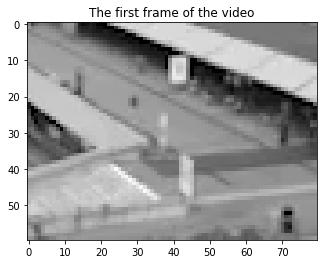

In [39]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

In [40]:
print(arr)

[[[117.  66.  95. ... 103. 116. 122.]
  [135. 115. 124. ... 104. 103. 102.]
  [115. 124. 133. ... 105. 105. 107.]
  ...
  [149. 138.  90. ... 123. 119. 117.]
  [150. 150. 116. ... 112. 111. 110.]
  [132. 129. 104. ... 128. 132. 135.]]

 [[117.  66.  95. ... 103. 116. 122.]
  [135. 115. 124. ... 104. 103. 102.]
  [115. 124. 133. ... 105. 105. 107.]
  ...
  [149. 138.  90. ... 123. 119. 117.]
  [150. 150. 116. ... 112. 111. 110.]
  [132. 129. 104. ... 128. 132. 135.]]

 [[117.  66.  95. ... 103. 116. 122.]
  [135. 115. 124. ... 104. 103. 102.]
  [115. 124. 133. ... 105. 105. 107.]
  ...
  [149. 138.  90. ... 123. 119. 117.]
  [150. 150. 116. ... 112. 111. 110.]
  [132. 129. 104. ... 128. 132. 135.]]

 ...

 [[109.  59.  89. ... 100. 109. 114.]
  [119. 104. 116. ...  98.  98.  97.]
  [109. 118. 123. ... 101. 102. 103.]
  ...
  [139. 133.  86. ... 111. 110. 110.]
  [142. 136. 103. ... 102. 100.  98.]
  [123. 118.  96. ... 119. 124. 126.]]

 [[109.  59.  89. ... 100. 109. 114.]
  [119. 104.

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

2883 60 80
[[117. 117. 117. ... 109. 109. 109.]
 [ 66.  66.  66. ...  59.  59.  59.]
 [ 95.  95.  95. ...  89.  89.  89.]
 ...
 [128. 128. 128. ... 119. 119. 119.]
 [132. 132. 132. ... 124. 124. 124.]
 [135. 135. 135. ... 126. 126. 126.]]


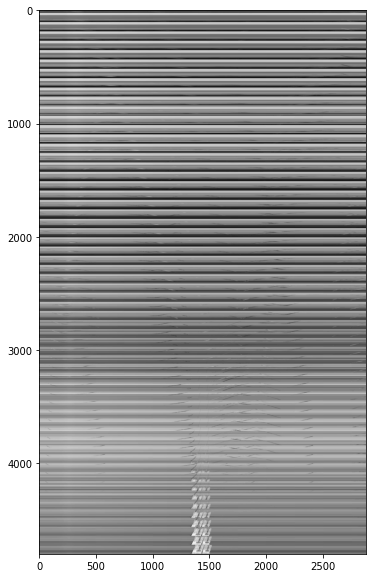

In [41]:
nframes, size_w, size_h = arr.shape
print(nframes, size_w, size_h)
M = arr.reshape((nframes, size_h * size_w)).T
print(M)
plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

[117.  66.  95. ... 128. 132. 135.]


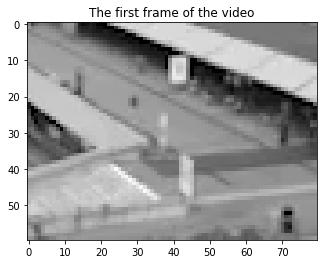

In [94]:
print(M[:,0])
first_frame = M[:,0].reshape((size_w, size_h)) # TO BE FILLED
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

In [43]:
u, s, vh = np.linalg.svd(M, full_matrices=False)
print(s)

[4.86153209e+05 1.46361630e+04 5.23807264e+03 ... 4.85504631e-11
 4.85504631e-11 9.66653197e-12]


In [44]:
s = s / s[0]
print(s)

[1.00000000e+00 3.01060708e-02 1.07745306e-02 ... 9.98665896e-17
 9.98665896e-17 1.98837152e-17]


Text(0, 0.5, 'Number')

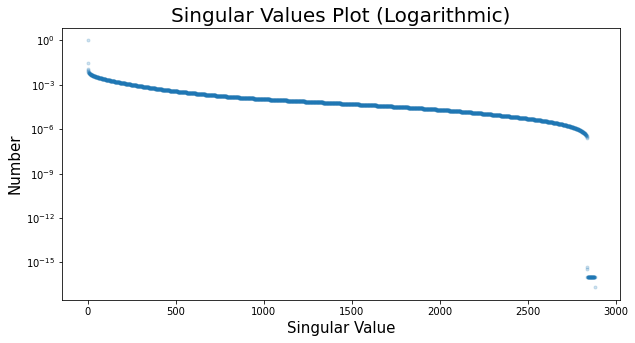

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.semilogy(s / s[0], '.', alpha=0.2, label='legend')
plt.title('Singular Values Plot (Logarithmic)', fontsize=20)
plt.xlabel('Singular Value', fontsize=15)
plt.ylabel('Number', fontsize=15)

Text(0, 0.5, 'Number')

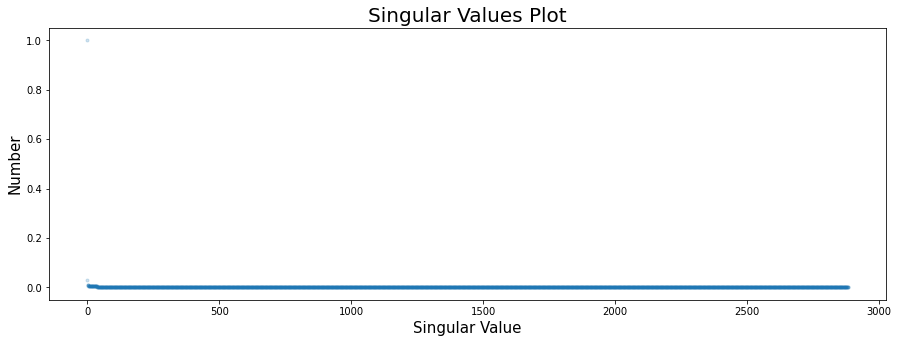

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(s / s[0], '.', alpha=0.2, label='legend')
plt.title('Singular Values Plot', fontsize=20)
plt.xlabel('Singular Value', fontsize=15)
plt.ylabel('Number', fontsize=15)

Первое сингулярное значение отражает большую часть данных, последнее - наименьшую. Так как видео статическое, то большая часть - это фон, меньшая - движущиеся объекты

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [47]:
from math import sqrt

def trunc_svd(M, r):
  u, s, vh = np.linalg.svd(M, full_matrices=False)
  r = min(r, len(s))

  s_squared = s * s
  rel_eps = sqrt(np.sum(s_squared[r:])) / sqrt(np.sum(s_squared))
  s = s[:r]
  u = u[:, :r]
  vh = vh[:r, :]
  Mr = u @ np.diag(s) @ vh

  # for i in range (r + 1, r + 1)
  # rel_eps = np.linalg.norm(M - Mr, 'fro') / np.linalg.norm(M, 'fro')
  
  return Mr, rel_eps

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [48]:
Mr, rel_eps = trunc_svd(M, 1)

In [49]:
rel_eps

0.055668544769737524

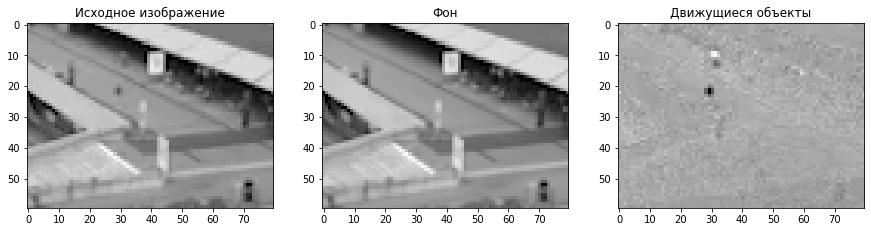

In [50]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(Mr[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((M[:,0] - Mr[:,0]).reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [51]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("/content/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


In [52]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = arr3.reshape((nframes, size_h * size_w)).T # TO BE FILLED
print(M3)

image size: 100 x 178, 
number of frames: 3600
[[152. 152. 152. ... 141. 141. 141.]
 [152. 152. 152. ... 141. 141. 141.]
 [152. 152. 152. ... 141. 141. 141.]
 ...
 [136. 136. 136. ... 125. 125. 125.]
 [136. 136. 136. ... 129. 129. 129.]
 [136. 136. 136. ... 123. 123. 123.]]


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [53]:
def rand_svd(M, r, oversampling=10):
  # algo 2
  R = np.random.randn(M.shape[1], r + oversampling)
  Y = M @ R
  Q, R = np.linalg.qr(Y)

  # algo 1
  B = Q.T @ M
  u, s, vh = np.linalg.svd(B, full_matrices=False)
  u = Q @ u
  Mr = u[:, :r] @ np.diag(s[:r]) @ vh[:r, :]
  return Mr


2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [54]:
Mr3 = rand_svd(M3, 1)

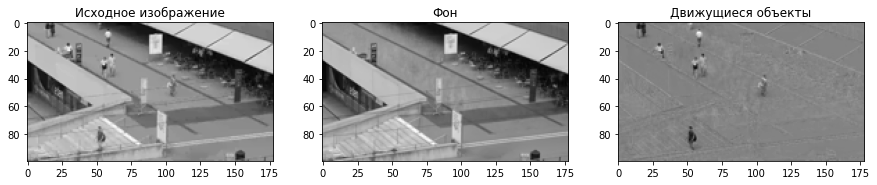

In [55]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M3[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(Mr3[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((M3 - Mr3)[:,0].reshape((size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

In [56]:
def rand_svd_rel_eps(M, r, overslamping=5):
  ans = 0
  num = 10
  for i in range(num):
    M_rand = rand_svd(M, r, overslamping)
    ans += np.linalg.norm(M_rand - M, ord='fro') / np.linalg.norm(M, ord='fro')
  return ans / num

In [57]:
p = np.arange(16) * 2
f = []
for i in p:
  f.append(rand_svd_rel_eps(M3, 2, i))

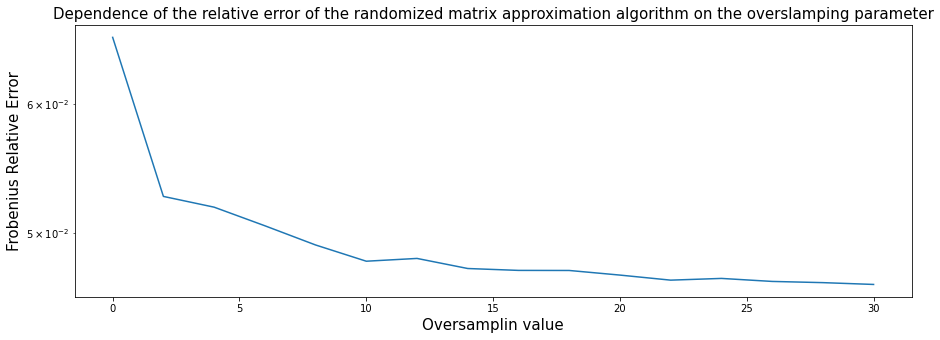

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(p, f, label='legend')
plt.semilogy()
plt.xlabel("Oversamplin value", fontsize=15)
plt.ylabel("Frobenius Relative Error", fontsize=15)
plt.title("Dependence of the relative error of the randomized matrix approximation algorithm on the overslamping parameter", fontsize=15);

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [59]:
video2 = mpe.VideoFileClip("/content/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [60]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [61]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

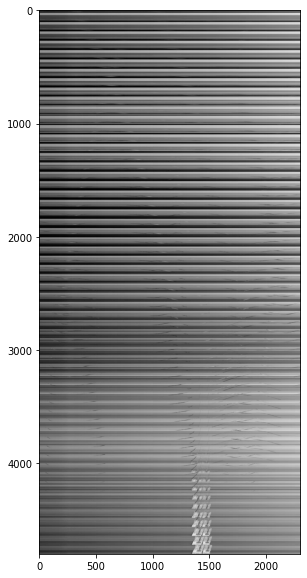

In [62]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape((nframes2, size_h * size_w)).T # TO BE FILLED
# print(M3)

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [63]:
M2_svd, M2_svd_rel_eps = trunc_svd(M2, 2)
M2_rand = rand_svd(M2, 2)

In [66]:
!echo "Trunc "
%timeit -o trunc_svd(M2, 2)
!echo "Rand "
%timeit -o rand_svd(M2, 2);

Trunc 
20.2 s ± 4.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Rand 
152 ms ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 152 ms ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [68]:
M2_rand_rel_eps = rand_svd_rel_eps(M2, 2)
print(M2_svd_rel_eps, M2_rand_rel_eps)

0.06063233098450478 0.06740656000452055


In [69]:
print(rel_eps, rand_svd_rel_eps(M3, 2))

0.055668544769737524 0.05239607203489024


In [74]:
print(rand_svd_rel_eps(M2, 2), rand_svd_rel_eps(M, 2))

0.07087587502390104 0.055003129669343974


In [75]:
print(M2_svd_rel_eps, rel_eps)

0.06063233098450478 0.055668544769737524


Для постоянного освещения ошибка меньше


Рандомизированный алгоритм работает хорошо и даже чуть лучше

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [76]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.T.reshape(nframes, size_w, size_h)
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [77]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

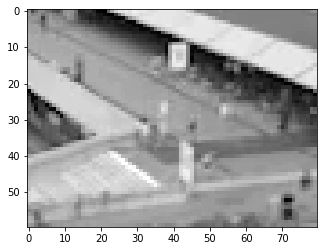

In [78]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [81]:
# YOUR CODE GOES HERE (duplicate code from trunc_SVD)
# U_2 = ...
# S_2 = ...
# VT_2  = ...
U_2, S_2, VT_2 = np.linalg.svd(M2, full_matrices=False)
U_2, S_2, VT_2 = U_2[:, :2], S_2[:2], VT_2[:2, :]

In [92]:
def project_new_frames(U, S, VT, new_frames):
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''
    return U @ (U.T @ new_frames)

4800


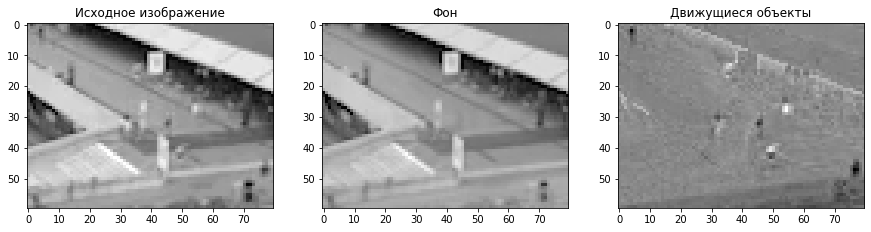

In [93]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)
print(new_frame_proj.size)
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(new_frame.reshape(size_w, size_h) - new_frame_proj.reshape(size_w, size_h), cmap='gray')
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [97]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = M = remaining.reshape((remaining_nframes, size_h * size_w)).T
M_full = np.concatenate((M2, M_remaining), axis=1)

In [98]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [99]:
r = 2
oversampling = 10

# YOUR CODE GOES HERE (duplicate code from rand_SVD)

R = np.random.randn(M.shape[1], r + oversampling)
Y = M @ R
Q, R = np.linalg.qr(Y)

B = Q.T @ M
u, s, vh = np.linalg.svd(B, full_matrices=False)
u = Q @ u

U_2_rand = u[:, :2]
S_2_rand = s[:2]
VT_2_rand = vh[:2, :]

In [100]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [101]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [104]:
np.linalg.norm(M_true - M_proj) / np.linalg.norm(M_true), np.linalg.norm(M_true - M_proj_rand) / np.linalg.norm(M_true)

(0.020001445065678095, 0.0770186901521682)

**Выводы:**

Относительная погрешность хуже почти в 4 раза на рандомном. Он более чувствителен к изменению фона (даже на видео видно)

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [105]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2023-02-16 14:38:34--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3.0K) [text/plain]
Saving to: ‘r_pca.py’

r_pca.py            100%[===================>]   3.03K  --.-KB/s    in 0s      

2023-02-16 14:38:34 (34.8 MB/s) - ‘r_pca.py’ saved [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

iteration: 1, error: 4.513709784780863
iteration: 100, error: 0.2920052692804005
iteration: 200, error: 0.17267051783121537
iteration: 300, error: 0.13108047253698774
iteration: 400, error: 0.11358066371147996
iteration: 500, error: 0.10911234560037827
iteration: 600, error: 0.07768399102107842
iteration: 700, error: 0.07342189454628557
iteration: 800, error: 0.060039227642945066
iteration: 900, error: 0.04662975730639094
iteration: 1000, error: 0.03957726662545866
iteration: 1100, error: 0.03172168618210725
iteration: 1200, error: 0.02418228872748867
iteration: 1300, error: 0.02675119538604167
iteration: 1400, error: 0.012061113442154077
iteration: 1500, error: 0.01801969771693061
iteration: 1519, error: 0.008163267638561646


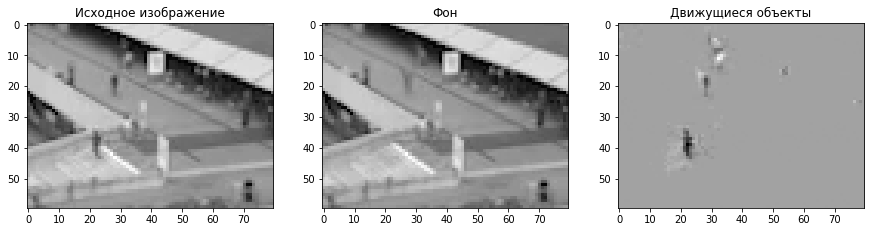

In [110]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(Mt[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(L[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(S[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [111]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.